In [1]:
# Python
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import r2_score
import os
os.listdir()
path = open('document.txt', 'r').read().strip()

In [2]:
files = os.listdir(path)
files.sort()
print(files)
print(path + files[0])
test_data_street = files[-3]
files = files[:-3]
print(files)
print(test_data_street)


['2015_street.feather', '2016_street.feather', '2017_street.feather', '2018_street.feather', '2019_street.feather', '2020_street.feather', '2021_street.feather']
C:/Users/Arcane/Documents/Data Challenge 2/2015_street.feather
['2015_street.feather', '2016_street.feather', '2017_street.feather', '2018_street.feather']
2019_street.feather


## Notes Police forces
apparently 'Greater Manchester Police' force was removed from 2020 to 2021 <br><br>
'Police Service of Northern Ireland' is included from 2011 onwards

## idea
instead of only count of crimes we select a specific crime type in a specific district

In [3]:
def DistrictCrimeData(district, allYears, crime):
    df_district = pd.DataFrame([])
    if allYears:
        for i in files:
            df_new = pd.read_feather(f"{path}/{i}")
            df_new = df_new[['Month', 'Falls within', 'Crime type']]
            df_new = df_new[df_new['Falls within']==district]
            if len(crime) != 0:
                df_new = df_new[df_new['Crime type'].isin(crime)]
            df_district = pd.concat([df_district, df_new], ignore_index=True)
            
    #only last year's data for testing
    else:
        df_district = pd.read_feather(f"{path}/{test_data_street}")
        df_district = df_district[['Month', 'Falls within', 'Crime type']]
        df_district = df_district[df_district['Falls within']==district]
        if len(crime) != 0:
            df_district = df_district[df_district['Crime type'].isin(crime)]

    return df_district

df_data = DistrictCrimeData(district='South Wales Police', allYears=True, crime=['Violence and sexual offences'])
df_test_data = DistrictCrimeData(district='South Wales Police', allYears=False, crime=['Violence and sexual offences'])


In [4]:
district = df_data.copy()
predict = {}

district = district.sort_values(by=['Month'])
months = district['Month'].unique()
for i in months:
    predict[i] = len(district[district['Month']==i])
predict = pd.DataFrame({'ds': list(predict.keys()), 'y': list(predict.values())})
predict['ds'] = pd.to_datetime(predict['ds'])


### Model creation

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\Arcane\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Arcane\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0.5, 34.0, 'Years')

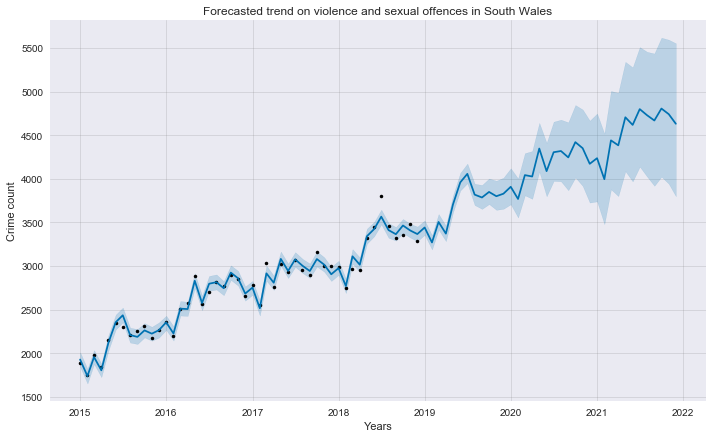

In [5]:
m = Prophet(seasonality_mode='additive', changepoint_prior_scale=0.5, seasonality_prior_scale=10).fit(predict)
future = m.make_future_dataframe(periods=36, freq='MS')
fcst = m.predict(future)
fig = m.plot(fcst)
ax = fig.gca()
ax.set_title('Forecasted trend on violence and sexual offences in South Wales')
ax.set_ylabel('Crime count')
ax.set_xlabel('Years')

### Seasonality and trend

C:\Users\Arcane\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Arcane\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


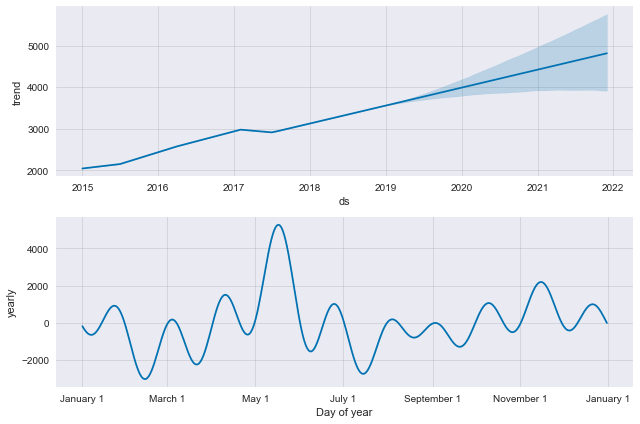

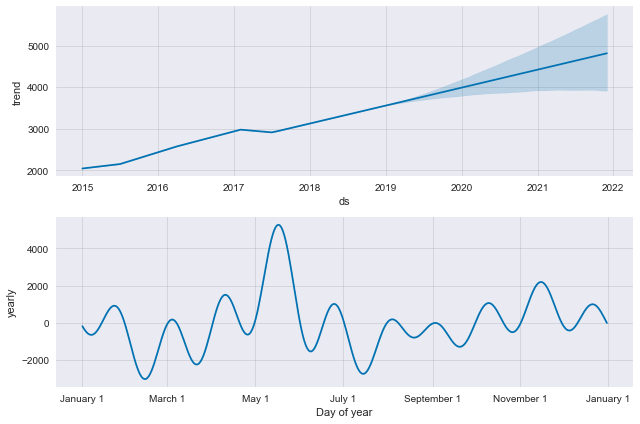

In [8]:
m.plot_components(fcst)

### Evaluation



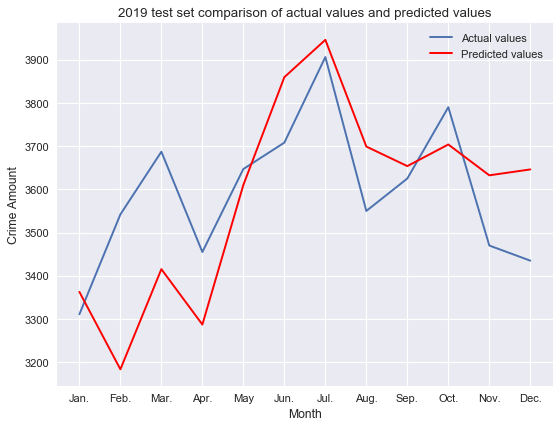

Test MSE: 30018.926
Test RMSE: 173.260
Test MAE: 142.910
r2 score: -0.178


In [9]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
fcst = fcst.sort_values(by='ds')
predict_2019 = []
for i, row in fcst.iterrows():
    if row[0] >= pd.Timestamp(2019, 1, 1, 0) and row[0] <= pd.Timestamp(2019, 12, 31, 0) :
        predict_2019.append(row[2])

df_2019 = df_test_data['Month'].value_counts()
df_2019 = df_2019.sort_index()
true_2019 = df_2019.values
r2 = r2_score(true_2019, predict_2019)
plt.plot(true_2019)
plt.plot(predict_2019, color='red')
plt.legend(['Actual values', 'Predicted values'])
plt.title('2019 test set comparison of actual values and predicted values')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], ['Jan.', 'Feb.', 'Mar.', 'Apr.', 'May', 'Jun.', 'Jul.', 'Aug.', 'Sep.', 'Oct.', 'Nov.', 'Dec.'])
plt.xlabel('Month')
plt.ylabel('Crime Amount')
plt.show()
mse = np.square(np.subtract(true_2019,predict_2019)).mean()
rmse = mse**0.5
sum=0
for i in range(len(true_2019)):
    sum += abs(true_2019[i] - predict_2019[i])
mae = sum/len(true_2019)
print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('r2 score: %.3f' % r2)

### Cross validation
Only to experiment

In [10]:
cutoffs = pd.date_range(start='2017-12-01', end='2017-12-01', freq='2MS')
df_cv = cross_validation(m, cutoffs=cutoffs, horizon = '365 days')

df_p = performance_metrics(df_cv)
print(df_p)
print('MSE: %.3f' % df_p['mse'].mean())
print('RMSE: %.3f' % df_p['rmse'].mean())
print('MAE: %.3f' % df_p['mae'].mean())

100%|██████████| 1/1 [01:02<00:00, 62.68s/it]

    horizon           mse        rmse         mae      mape     mdape  \
0   31 days  44725.771076  211.484683  211.484683  0.070754  0.070754   
1   62 days  37074.335047  192.546968  192.546968  0.069992  0.069992   
2   90 days  75628.857934  275.007014  275.007014  0.092626  0.092626   
3  121 days  10087.312699  100.435615  100.435615  0.033931  0.033931   
4  151 days    563.823625   23.744971   23.744971  0.007148  0.007148   
5  182 days    474.934943   21.793002   21.793002  0.006317  0.006317   
6  212 days  89830.664944  299.717642  299.717642  0.078852  0.078852   
7  243 days  31220.458968  176.693121  176.693121  0.051008  0.051008   
8  274 days  23945.602461  154.743667  154.743667  0.046596  0.046596   
9  304 days  30169.814299  173.694601  173.694601  0.051710  0.051710   
10 335 days  14521.856118  120.506664  120.506664  0.034589  0.034589   
11 365 days  18470.456426  135.906057  135.906057  0.041284  0.041284   

       smape  coverage  
0   0.068337       0.0  


C:\Users\Arcane\Anaconda3\lib\site-packages\prophet\plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
C:\Users\Arcane\Anaconda3\lib\site-packages\prophet\plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
C:\Users\Arcane\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Arcane\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for mult

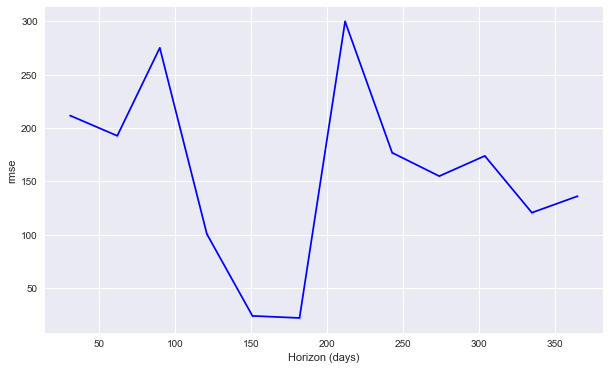

In [11]:
from prophet.plot import plot_cross_validation_metric 
fig = plot_cross_validation_metric(df_cv, metric='rmse')


### Other data aggregation


In [12]:
df_data0 = pd.read_feather(f"{path}/{files[0]}")
df_data1 = pd.read_feather(f"{path}/{files[1]}")
df_data2 = pd.read_feather(f"{path}/{files[2]}")
df_data3 = pd.read_feather(f"{path}/{files[3]}")


In [13]:

crimes = df_data0['Crime type'].value_counts().keys()
crimeCount0 = df_data0['Crime type'].value_counts()
crimeCount1 = df_data1['Crime type'].value_counts()
crimeCount2 = df_data2['Crime type'].value_counts()
crimeCount3 = df_data3['Crime type'].value_counts()
dic0 = dict(zip(crimes, crimeCount0))
dic1 = dict(zip(crimes, crimeCount1))
dic2 = dict(zip(crimes, crimeCount2))
dic3 = dict(zip(crimes, crimeCount3))
df_crime_distribution = pd.DataFrame(columns=crimes)
df_crime_distribution = df_crime_distribution.append(dic0, ignore_index=True)
df_crime_distribution = df_crime_distribution.append(dic1, ignore_index=True)
df_crime_distribution = df_crime_distribution.append(dic2, ignore_index=True)
df_crime_distribution = df_crime_distribution.append(dic3, ignore_index=True)
df_crime_distribution

,Anti-social behaviour,Violence and sexual offences,Criminal damage and arson,Other theft,Burglary,Vehicle crime,Shoplifting,Public order,Drugs,Bicycle theft,Theft from the person,Other crime,Robbery,Possession of weapons
0,1875251,1049161,549145,505583,410576,368568,339123,193944,151248,88163,83092,63224,51628,25162
1,1852894,1233265,571144,497262,409399,394556,362286,254027,137670,86726,83586,74172,56130,31229
2,1712771,1512942,603824,544405,458419,445689,389625,367198,136784,102983,100667,93174,74329,40137
3,1789313,1436624,577112,552890,467788,435702,430086,379399,148270,103570,101242,96848,82621,45848


In [14]:
df_crime_distribution1 = pd.DataFrame(columns=crimes)
df_crime_distribution1 = df_crime_distribution1.append(dic0, ignore_index=True)

In [15]:
#df_crime_distribution.to_feather(f"C:/Users/Arcane/Documents/Data Challenge 2/extra")

Text(0.5, 1.0, 'Amount of crime for each crime type per year')

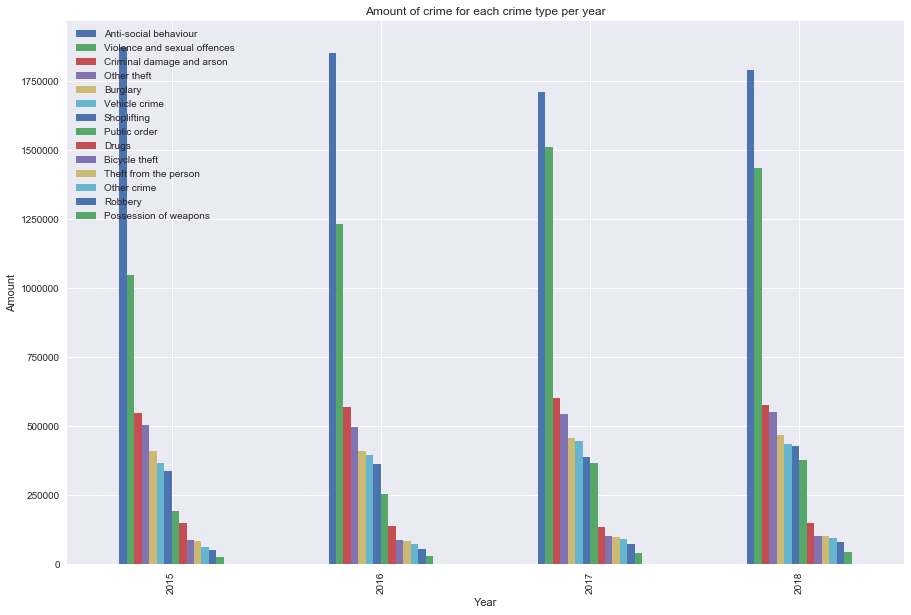

In [16]:
ax = df_crime_distribution.plot.bar(figsize=(15,10))
ax.set_xticklabels([2015, 2016, 2017, 2018, 2019])
ax.set_xlabel('Year')
ax.set_ylabel('Amount')
ax.set_title('Amount of crime for each crime type per year')


In [17]:
sum0 = sum(crimeCount0)
sum1 = sum(crimeCount1)
sum2 = sum(crimeCount2)
sum3 = sum(crimeCount3)

df_total_crimes = pd.DataFrame(data = {'Total crimes' : [sum0,sum1,sum2,sum3]})
print(df_total_crimes)
plt.plot(df_total_crimes)
plt.rcParams["figure.figsize"] = (10,5)
plt.xticks([0, 1, 2, 3], ['2015', '2016', '2017', '2018'])

TypeError: 'numpy.float64' object is not callable

In [ ]:
plt.plot(df_crime_distribution)
plt.rcParams["figure.figsize"] = (15,10)
plt.xticks([0, 1, 2, 3], ['2015', '2016', '2017', '2018'])
plt.legend(crimes, loc='upper right')